-- The **Physical Network** of Devices is generated using function *PHY_NET* in the first step by giving $\text{num\_dev}$ as the number of Devices. To this end, the **CPU/GPU/Memory/Storage** profiles are randomly generated for each Device after placement of Devices in the environment randomly. 

-- A link in Physical Network is established between two Devs if their relative distance is no larger than $R_{max}$ ($\text{dev\_dev\_mxd}$). By considering a fixed **Bandwidth** for all links, throughput of each link is computed as weight value of each link denoting the maximum data-transfer capacity of each link. The link throughput is computed based on the **Shannon-Hartley formula** which computes throughput of a link as a function of _transmit power_($Pt$), _background noise_($Pn$), _relative distance_, and _channel bandwidth_($BW$) between the pair of transmitter and receiver nodes forming their associated link. By defining $SINR$ as signal-to-noise-plus-interference ratio and $FSPL$ as Free-Space-Path-Loss, the details are as follows:  
$$ Throughput(Mbps) = BW(MHz) * \log_{2}(1+SINR) \\
SINR(dBm) = P_{t}(dBm) - P_{n}(dBm) - FSPL(dBm) \\
FSPL(dBm) = k_{1} * log_{10}(\tfrac{Transceiver-Distance}{R_{max}}) + k_{2} $$
for $k_{1}$ and $k_{2}$ as constants. The dimensions ($\text{dim}$) of the environment are given by $X_{max}$ ($\text{Xmax}$) and $Y_{max}$ ($\text{Ymax}$). Matrix $\text{FF}$ contains _CPU/GPU/Memory/Storage_ sample profiles for Devices whose values are determined based on the usecase. Note that resources of all nodes of PHY-NET are chosen from possibilties provided by $\text{FF}$.

-- Fig.1 depicts the poistion of Devices in the environment, and labels of each Device containing: Index of Device along with CPU/GPU/Memory/Storage profile of Device. Fig.2 depicts topology of Physical Network where each link of the graph is labeled with: Throughput of that channel and the Relative Distance between Devices of that channel.

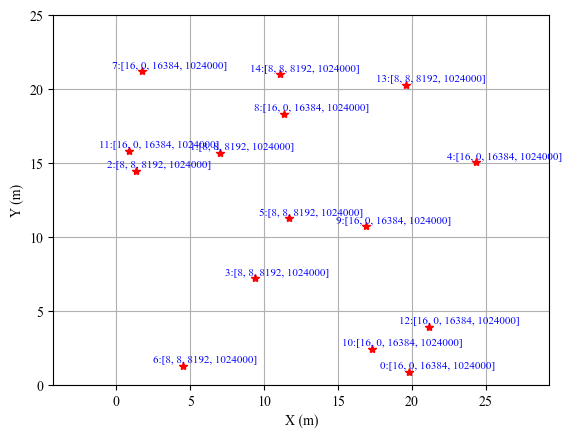

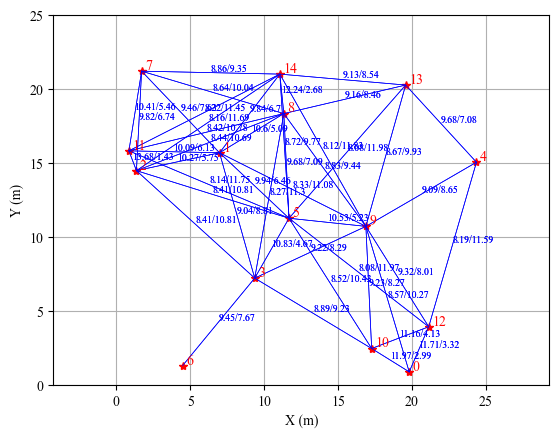

In [71]:
import numpy as np
import pdb
import copy
import random
import matplotlib.pyplot as plt
import scipy as opt
import math
import sys
#!pip install pulp --progress-bar off 
#import pulp

######################################### Definition of function PHY_NET
def PHY_NET(num_dev, dim, dev_dev_mxd, Xmax, Ymax, BW, Pt, Pn, FF):
    
    Lim=[Xmax, Ymax]
    pos_dev=np.array([[0 for col in range(num_dev)] for row in range(dim)], dtype=float)          #Randomly-generated position of all Devices in 2D (m)
    for j in range(num_dev):
        for k in range(len(Lim)):
            #pos_dev[k][j]=(Lim[k] * np.random.rand())        
            pos_dev[k][j]=np.ceil((Lim[k]*np.random.rand(1,1))*100)/100 

    #print(num_dev, Lim, dev_dev_mxd, len(Lim))
    #print(f"pos_dev =", pos_dev)
    
    xx=(np.random.randint(2, size=num_dev))    #Choose randomly the resource of each Device out of 2 described choices for its type
    cap_dev_nod=np.array([[0 for col in range(len(FF[1]))] for row in range(num_dev)], dtype=dict)
    for i in range(num_dev):
        for j in range(len(FF[1])):
            cap_dev_nod[i][j]=FF[xx[i]][j]

    adj_dev_lnk=np.array([[0 for col in range(num_dev)] for row in range(num_dev)], dtype=int)      # Binary adjacency matrix for the network of Devices
    cap_dev_lnk=np.array([[0 for col in range(num_dev)] for row in range(num_dev)], dtype=float)    # Throughput weight matrix for the network of Devices

    # Evaluate matrices adj_dev_lnk and cap_dev_lnk after taking into account the impact of maximum distance Rmax on each link of the network of Devices 
    for i in range(num_dev):
        for j in range(num_dev):
            if i!=j and np.linalg.norm(pos_dev[:, i] - pos_dev[:, j])<=dev_dev_mxd:
                adj_dev_lnk[i][j]=1
                cap_dev_lnk[i][j]=round(BW*np.log2(1 + Pt - Pn - 0.9*np.log10((np.linalg.norm(pos_dev[:,i]-pos_dev[:,j]))/dev_dev_mxd)), 2)

    #print(cap_dev_nod, xx)
    #print(adj_dev_lnk, cap_dev_lnk)
    np.save("pos_dev.npy", pos_dev)
    np.save("cap_dev_nod.npy", cap_dev_nod)
    np.save("cap_dev_lnk.npy", cap_dev_lnk)
    np.save("adj_dev_lnk.npy", adj_dev_lnk)

    return pos_dev, cap_dev_nod, cap_dev_lnk, adj_dev_lnk

#########################################
######################################### Implementation (All Parameters)
# Inputs parameters of all cells aer evaluated here. 
# To generate new topology for PHY-NET or keeps current PHY-NET => uncomment of comment line 77 of this cell
# To generate new topology for APP-NET or keeps current APP-NET => uncomment of comment line 74 of the next cell   
np.set_printoptions(precision=4)
num_dev: int=15                                            #Number of Devices
dim: int=2                                                 #Dimension of deployment space
Xmax: float=25                                             #Range of area of interset in X direction (m)
Ymax: float=25                                             #Range of area of interset in Y direction (m)
dev_dev_mxd: float=12                                      #Maximum allowed distance between two Devices to form a communication link 
#delt: float=0.01
# 2 differetn types of resources that each Devices can use in terms of its CPU[GHz]/GPU[GHz]/MEM[Mbits]/STR[Mbits]
FF=[[8,  8,  8.192e3,  1024e3], 
    [16, 0,  16.384e3, 1024e3]]
BW: float=10                                               #Fixed BW of each link in MHz
Pt: float=5                                                #Fixed transmit power of transmitter node in dBm
Pn: float=4.25                                             #Fixed noise power of environment in dBm
app_dev_mxd: float=15        #Radius of a circle centered at an application inside which eligible devices to address that application are positioned 
hop_thr =5                   #Upper-bound on hop-count of the allowed CSP determined by the user as a function of acceptable Latency
num_app: int = 60 #20        #Number of Applications
GG =[[0.5, 1, 2],            #All available choices for CPU demand of Comps 
    [0, 0, 0, 0, 0.5, 1, 2], #All available choices for GPU demand of Comps 
    [4096*0.1],              #Only one choice for Memory of each Comp 
    [10240]]                 #Only one choice for Storage of each Comp
#########################################

pos_dev, cap_dev_nod, cap_dev_lnk, adj_dev_lnk = PHY_NET(num_dev, dim, dev_dev_mxd, Xmax, Ymax, BW, Pt, Pn, FF)

pos_dev=np.load("pos_dev.npy", allow_pickle=True)
cap_dev_nod=np.load("cap_dev_nod.npy", allow_pickle=True)
cap_dev_lnk=np.load("cap_dev_lnk.npy", allow_pickle=True)
adj_dev_lnk=np.load("adj_dev_lnk.npy", allow_pickle=True)

########################################################## PLOT 1
for i in range(num_dev):
    plt.plot(pos_dev[0][i], pos_dev[1][i], 'r*')
    plt.text(pos_dev[0][i]-2, pos_dev[1][i]+0.2, str(i)+":["+str(cap_dev_nod[i][0])+\
             ", "+str(cap_dev_nod[i][1])+", "+str(int(cap_dev_nod[i][2]))+", "+str(int(cap_dev_nod[i][3]))+"]", color = "blue", fontsize=8)  
    # for j in range(num_dev):
    #     if i!=j and adj_dev_lnk[i][j]==1:
    #         plt.plot([pos_dev[0][i], pos_dev[0][j]], [pos_dev[1][i], pos_dev[1][j]], 'b', linewidth=0.5)
    #         plt.text(0.5*(pos_dev[0][i]+pos_dev[0][j]), 0.5*(pos_dev[1][i]+pos_dev[1][j])+0.1, str(cap_dev_lnk[i][j]), color = "blue", fontsize=7)
    
plt.grid(True)
plt.axis('equal')
plt.rcParams["font.family"] = "Times New Roman"
plt.xlim((0, Xmax))
plt.ylim((0, Ymax))
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.savefig("FF1.jpg")
plt.savefig("FF1.pdf")
plt.show()

########################################################## PLOT 2
for i in range(num_dev):
    plt.plot(pos_dev[0][i], pos_dev[1][i], 'r*')
    plt.text(pos_dev[0][i]+0.25, pos_dev[1][i]+0.1, str(i), color = "red")  
    for j in range(num_dev):
        if i!=j and adj_dev_lnk[i][j]==1:
            plt.plot([pos_dev[0][i], pos_dev[0][j]], [pos_dev[1][i], pos_dev[1][j]], 'b', linewidth=0.5)
            plt.text(0.5*(pos_dev[0][i]+pos_dev[0][j]), 0.5*(pos_dev[1][i]+pos_dev[1][j])+0.1, \
                     str(cap_dev_lnk[i][j])+"/"+str(round(np.linalg.norm(pos_dev[:, i] - pos_dev[:, j]), 2)), color = "blue", fontsize=7)

plt.grid(True)
plt.axis('equal')
plt.rcParams["font.family"] = "Times New Roman"
plt.xlim((0, Xmax))
plt.ylim((0, Ymax))
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.savefig("FF2.jpg")
plt.savefig("FF2.pdf")
plt.show()

# print(cap_dev_nod, cap_dev_lnk)

-- The set of Applications are generated in this step using *APP_NET* function. By giving $\text{num\_app}$ as the number of Applications, each Application is randomly placed in a physical position within an environment with dimensions of $X_{max}$(Xmax) and $Y_{max}$(Ymax).

-- Each Application is composed of **Minimum One** and **Maximum Three** number of Components in this code forming the **Virtual Network** of each Appliction with a **Line Topology**. Topology of the VIR-NET of each App is determined by random evaluation of array $\text{comp\_app}$ with elements of the set $\{1,2,3\}$. Note that $\text{num\_comp}=sum(\text{comp\_app})$ is computed by summing up all elements of array $\text{comp\_app}$. The links of the VIR-NET of each App is then formed such that: 0 link for 1 virtual node topology, 1 link for 2 virtual nodes topology, and 2 links for 3 virtual nodes topology.   

-- Moreover, each Comp of each App has its nodal resource demands in terms of **CPU/GPU/Memory/Storage** to be picked from array $\text{GG}$. This array contains a set of CPU and GPU values that can be randomly picked for every Comp of each App, while it has upper-bounds on vaules of Memory and Storage for each Comp of the App that are randomly generated as well. This results in generation of $\text{cap\_comp\_nod}$ for nodal demands of Comps of each App. Since an App is addressed once all of its Comps are addressed, one can compute the overall **CPU/GPU/Memory/Storage** resource demand of each App as summation of these values of all of its Comps by generating $\text{cap\_app\_nod}$.

-- Link throughput is considered as resource demand of links in the VIR-NET of each App with line topology. To this end, a random value is generated for each virtual link with an upper-bound being a fraction of the smallest throuhput of the links in **Physical Network**. This reuslts in generation of link demands array $\text{cap\_comp\_lnk}$ of all Comps of Apps. 

-- Fig.3 depicts the position of the Apps where the label of each App contains: Index of App, Number of Comps of App, and its cumulative CPU/GPU/Memory/Storage demands. 

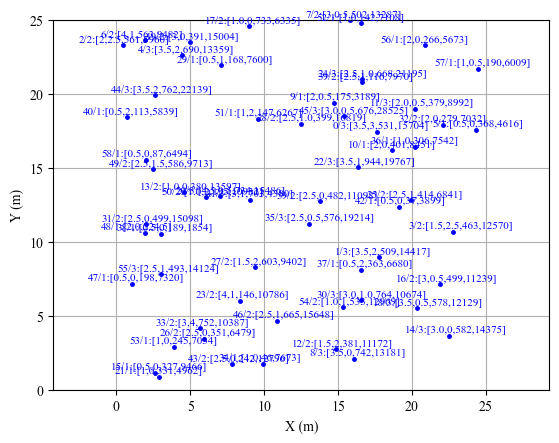

In [72]:
######################################### Definition of function APP_NET
def APP_NET(num_app, dim, Xmax, Ymax, FF, GG):
    Lim=[Xmax, Ymax]
    pos_app=np.array([[0 for col in range(num_app)] for row in range(dim)], dtype=float)     #Randomly-generated position of apos_app Apps in 2D (m)
    for i in range(num_app):
        for j in range(len(Lim)):
            pos_app[j][i]=np.ceil((Lim[j]*np.random.rand(1,1))*100)/100
    comp_app=(np.random.randint(3, size=num_app) + np.ones((num_app,), dtype=int))           
    #If comp_app=1->single-component app/comp_app=2->two component app/comp_app=3->three component app
    num_comp=np.sum(comp_app)                                 #Number of Components of Applications
    cap_comp_nod=np.array([[0 for col in range(len(FF[1]))] for row in range(num_comp)], dtype=dict)  #Demand row of each individual Component 
    cap_app_nod=np.array([[0 for col in range(len(FF[1]))] for row in range(num_app)], dtype=dict) 
    #Cumulative demand row of each Application [computed as sum of its Components]

    # Evaluating matrix cap_comp_nod
    for i in range(num_comp):
        for j in range(len(FF[1])):
            if j==0 or j==1:
                cap_comp_nod[i][j]=GG[j][int(np.random.randint(len(GG[j]), size=1))]
            elif j==2 or j==3:
                cap_comp_nod[i][j]=float(np.ceil((GG[j][0]*np.random.rand(1,1))*100)/100)

    # Evaluating matrix cap_app_nod
    c: int=0                                      #Counter used in iteration
    for i in range(num_app):
        for j in range(len(FF[1])):
            cap_app_nod[i][j]=np.sum(cap_comp_nod[c:c+comp_app[i], j])
        c=c+comp_app[i]    

    #print(comp_app, num_comp)
    #print(cap_comp_nod)
    #print(cap_app_nod)
    SumR=[]     #Summation of Resources of all Devs in terms of CPU/GPU/MEM/STR 
    SumD=[]     #Summation of Demands of all Apps in terms of CPU/GPU/MEM/STR
    for j in range(len(FF[1])):
        SumR.append(np.sum(cap_dev_nod[:, j]))
        SumD.append(np.ceil(np.sum(cap_comp_nod[:, j])*100)/100)
    # print(f"Total Resource Supply of All Devices =", SumR, "\n")
    # print(f"Total Resource Demand of All Applications =", SumD)

    # Randomly-generated matrix SS for Throughput of v-links between Components of Virtual Graph of each App (only for Apps with 2 or 3 Comps with 1-2 and 1-2-3 topologies)
    cap_comp_lnk=np.array([[0 for col in range(num_comp)] for row in range(num_comp)], dtype=float)     
    ss=4*min(cap_dev_lnk[i][j] for i in range(num_dev) for j in range(num_dev) if cap_dev_lnk[i][j]>0)   
    # Smallest Throughput of Devs links so that ss/4 provides upper-bound on throughput of link of Apps  
    c: int=0                                      #Counter used in iteration
    for i in range(num_app):
        if comp_app[i]==1:    #No v-link exists
            c=c+comp_app[i]
        elif comp_app[i]==2:  #One v-link exists 1-2 and 2-1 for undirected topology
            a=np.ceil((ss/3)*np.random.rand(1,1)*100)/100 
            cap_comp_lnk[c][c+1]=a
            cap_comp_lnk[c+1][c]=a
            c=c+comp_app[i]
        elif comp_app[i]==3:  #Two v-links 1-2 and 2-3 exist along with 2-1 and 3-2 for undirected topology
            a=np.ceil((ss/3)*np.random.rand(1,1)*100)/100
            b=np.ceil((ss/3)*np.random.rand(1,1)*100)/100 
            cap_comp_lnk[c][c+1]=a
            cap_comp_lnk[c+1][c]=a
            cap_comp_lnk[c+1][c+2]=b
            cap_comp_lnk[c+2][c+1]=b
            c=c+comp_app[i]
    # print(cap_comp_lnk)
    np.save("num_comp.npy", num_comp)
    np.save("comp_app.npy", comp_app)
    np.save("pos_app.npy", pos_app)
    np.save("cap_comp_nod.npy", cap_comp_nod)
    np.save("cap_app_nod.npy", cap_app_nod)
    np.save("cap_comp_lnk.npy", cap_comp_lnk)

    return num_comp, comp_app, pos_app, cap_comp_nod, cap_app_nod, cap_comp_lnk

#########################################
######################################### Implementation     
num_comp, comp_app, pos_app, cap_comp_nod, cap_app_nod, cap_comp_lnk = APP_NET(num_app, dim, Xmax, Ymax, FF, GG)

num_comp=np.load("num_comp.npy", allow_pickle=True)
comp_app=np.load("comp_app.npy", allow_pickle=True)
pos_app=np.load("pos_app.npy", allow_pickle=True)
cap_comp_nod = np.load("cap_comp_nod.npy", allow_pickle=True)
cap_app_nod=np.load("cap_app_nod.npy", allow_pickle=True)
cap_comp_lnk=np.load("cap_comp_lnk.npy", allow_pickle=True)

########################################################## PLOT 3
for i in range(num_app):
    plt.plot(pos_app[0][i], pos_app[1][i], 'bo', markersize=2.5)
    plt.text(pos_app[0][i]-3, pos_app[1][i]+0.2, str(i)+"/"+str(comp_app[i])+":["+str(cap_app_nod[i][0])+","+str(cap_app_nod[i][1])+","\
              +str(int(cap_app_nod[i][2]))+","+str(int(cap_app_nod[i][3]))+"]", color = "blue", fontsize=8)  
    
plt.grid(True)
plt.axis('equal')
plt.rcParams["font.family"] = "Times New Roman"
plt.xlim((0, Xmax))
plt.ylim((0, Ymax))
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.savefig("FF3.jpg")
plt.savefig("FF3.pdf")
plt.show()


-- After generating the PHY_NET and APP_NET, **Workload Palcement** problem is addressed in this based on **Overall Optimization** approach. More specifically, the problem is broken into two subsequent **Node-Mapping** and **Link-Mapping** sub-problems, whre the first **Link-Mapping** sub-problem is optimally solved. 

-- First, the optimal-Node-Mapping problem is solved by formulating an ILP. To this end, define $num\_dev$ as number of Devs, $num\_app$ as number of Apps, $num\_comp$ as number of Comps, $comp\_app$ as an array denoting the number of Comps for each App, $cap\_dev\_nod$ which contains the resource capacity of each Dev of 4 different nodal resource types **CPU/GPU/Memory/Storage**, and $cap\_comp\_nod$ containing the nodal resource demand of each Comp of each App with 4 different resource types CPU/GPU/Memory/Storage. A Comp of an App can be potentially adderessed by any Dev positioned no more than $d_{max}$ ($app\_dev\_mxd$) distance away from it, introducing extra contraints. This distance constraint defined based on $app\_dev\_mvx$ generates a potentially non-empty set of candidate Devs forming a **"Cluster"** associatd with Comps of any App. Out of all candidates Devs that a Comp of an App can be assigned to, the priority is given to the closests device with smaller relative distance subject to having enough residual resources available to address the resource demands of at least one Comp of the App. In addition, an App is called **successfully-addressed** if and only if all of its Comps are successfully deployed on some of the Devs of the **PHY-NET**. Thus, an App is designated **unaddressed** even if one Comp of it remains unassigned. Summation of the resource demands of a certain type imposed by all Comps of all the Apps on one any Devshould remain less than the total capacity which that Dev is able to address for that certain reource type. 

-- After formulating all the above-mentioned conditions as **ILP constraints** and defining the total number of successfully-addressed Apps by the available resources of the PHY-NET as **ILP objective function**, function **$O\_N\_M()$** is defined to maximize the defined obejctive function subject to its constraints an an ILP. This ILP is solved using PULP library of python and the optimization results are saved in binary arrarys $comp\_dev\_asg$ and $app\_dev\_asg$.  


In [73]:
############################################### Workload-Placement by subsequent solving of 1) Optimal-Node-Mapping and 2) Greedy-Link-Mapping  
%pip install pulp --progress-bar off 
from pulp import *
import pulp as pp
import pandas as pd
import copy

######################################### Definition of function O_N_M for Optimal-Node-Mapping
def O_N_M(num_dev, num_comp, num_app, pos_app, comp_app, cap_comp_nod, cap_dev_nod, app_dev_mxd):

    pos_comp=np.array([[0 for col in range(num_comp)] for row in range(dim)], dtype=float)     #Position of all Comps of all Apps in 2D (m)
    c: int=0              #Counter used in iteration
    for i in range(num_app):
        for j in range(comp_app[i]):
            pos_comp[:,c+j]=pos_app[:,i]
        c = c + comp_app[i]     

    prob = pp.LpProblem("ILP_Problem", pp.LpMaximize)

    # Parameter Evaluation

    # CL=np.array([[0 for col in range(num_dev)] for row in range(num_comp)], dtype=float)
    # dik = [cap_dev_nod[i][k] for i in range(num_dev) for k in range(len(FF[1]))]
    # puk = [cap_comp_nod[u][k] for u in range(num_comp) for k in range(len(FF[1]))]

    ZE=np.array([0 for col in range(num_app+1)], dtype=int)
    c: int=0              #Counter used in iteration
    for i in range(num_app):
        c = c + comp_app[i]
        ZE[i+1]=c

    # Decision Variables
    x = pp.LpVariable.dicts("x", [(u,i) for u in range(num_comp) for i in range(num_dev)], 0, 1, cat="Binary")
    #y = pp.LpVariable.dicts("y", [s for s in range(num_app)], cat="Binary")

    # Cost Function
    # prob += pp.lpSum(y[s] for s in range(num_app))
    prob += pp.lpSum(x[(u,i)] for u in range(num_comp) for i in range(num_dev))

    # Constraints
    # for s in range(num_app):
    #     prob += (pp.lpSum(x[(u,i)] for i in range(num_dev) for u in range(num_comp)) >= y[s]*comp_app[s])

    for i in range(num_dev):
        for k in range(len(FF[1])):
            #prob += pp.lpSum(x[(u,i)]*puk[u,k] for u in range(num_comp)) <= dik[i,k]
            prob += (pp.lpSum(x[(u,i)]*cap_comp_nod[u][k] for u in range(num_comp)) <= cap_dev_nod[i][k]) 

    for i in range(num_dev):
        for u in range(num_comp):
            #prob += (np.linalg.norm(pos_dev[:,i]-pos_comp[:,u]) <= app_dev_mxd*x[(u,i)])
            prob += (((pos_dev[0][i]-pos_comp[0][u])**2 + (pos_dev[1][i]-pos_comp[1][u])**2)*x[(u,i)] <= (app_dev_mxd**2))

    for u in range(num_comp):
        prob += (pp.lpSum(x[(u,i)] for i in range(num_dev)) <= 1)

    for s in range(num_app):
        prob += (pp.lpSum(x[(u,i)] for u in range(ZE[s], ZE[s+1]) for i in range(num_dev)) == comp_app[s])    

    prob.solve()


    # print("Status:", LpStatus[prob.status])
    # print("Cost Value = ", value(prob.objective))
    # print(f"num_dev=", num_dev, f",  num_app=", num_app, f",  num_comp=", num_comp, f",  comp_app=", comp_app, f",  ZE=", ZE)

    # for v in prob.variables():
    #     print(v.name, "=", v.varValue)
    comp_dev_asg=np.array([[0 for col in range(num_comp)] for row in range(num_dev)], dtype=float)
    app_dev_asg=np.array([[0 for col in range(num_app)] for row in range(num_dev)], dtype=float)
    for i in range(num_dev):
        for u in range(num_comp):
            if x[(u,i)].value() == 1.0:
                comp_dev_asg[i][u]=1

    c =0
    for s in range(num_app):
        b=0
        bb=[]
        for u in range(ZE[s], ZE[s+1]):
            for i in range(num_dev):
                if x[(u,i)].value() == 1.0:
                    b += x[(u,i)].value()
                    bb.append(i)
            # if x[(u,i)].value() == 1.0:
            #     comp_dev_asg[i][u]=1
            #b = b and (x[(u,i)].value() == 1.0)
        #if b == True:
        if b == comp_app[s]:    
            c += 1
            # print(f"Application {s} is deployed on Device(s) {bb}")
            if len(bb)>0:
                for j in range(len(bb)):
                    app_dev_asg[bb[j]][s]+=1
            # for j in len(bb):
            #     app_dev_asg[bb[j]][s]=1
            # app_dev_asg[i][s]=1
    ###############################################
    cc=0
    DD={i:[] for i in range(num_app)}
    sxx={i:[] for i in range(num_app)}   
    for j in range(num_app):
        sx={"s":[]}
        for i in range(num_dev):
            if app_dev_asg[i,j]==1:
                sx["s"].append(i)                    

        if sx["s"]!=[]:
            DD[j]=["App "+str(j)+"("+str(comp_app[j])+"Comps)"+" deployed on Device(s): "+str(sx["s"])+" in O-Node-Mapping step (Partial-S)"]
            cc +=1
            # print(f"Application", j, f"is deployed on Device(s):", sx["s"], f"in Node-Mapping step (Partial-Success)")
            sxx[j]=sx["s"]
        elif sx["s"]==[]:  
            DD[j]=["App "+str(j)+"("+str(comp_app[j])+"Comps)"+" failed in O-Node-Mapping step (Total-F)"]
            # print(f"Application", j, f"failed to be deployed in Node-Mapping step (Total-Failure)")
                    
    np.save("num_app_NO.npy", cc)
    np.save("pos_comp.npy", pos_comp)
    np.save("comp_dev_asg_NO.npy", comp_dev_asg)
    np.save("app_dev_asg_NO.npy", app_dev_asg)                
    # print(cc)
    return comp_dev_asg, app_dev_asg, pos_comp, DD, cc
    ###############################################

    # s1=np.load("num_app_asg_NO.npy", allow_pickle=True)
    # print(f"{s1} of {num_app} Apps successfully passed O-Node-Mapping")

Note: you may need to restart the kernel to use updated packages.


-- To address **Greedy-Link-Mapping** part of Workload Placement, an algorithm based on **Constrained Dijkstra's Algorithm** is used to find the **Constrained_Shortest-Path** (CSP). First, the Apps are prioritized based on the cumulative nodal and link demands of their Comps in a lexicogrpahical manner. If an App is composed of only **1 Comp** wih no VIR-NET topology, Link-Mapping problem is not defined for this App. If an App is composed of **2 or more Comps** and **at least 2 Comps of the App are mapped onto 2 different nodes of the PHY-NET** in the previous Node-Mapping step, the Link-Mapping problem is defined, and one needs to map the virtual links between any pair of distinct Comps of this App in VIR-NET with a given throughput value onto a path inside the PHY-NET. To this end, one of the nodes in PHY-NET is chosen as the **source_node** $src\_nod$ and **Constrained Dijkstra's Algorithm** is implemented to find an **Unpslittable** shortest-path starting from $src\_nod$ and ending in **Destination Node** $des\_nod$ such that: **1)** The hop-count of the shortest-path path does not exceed $hop\_thr$ and **2)** all links with throughput less than throughput threshold of $trp\_thr$ are ignored after implementation of sub-function **Constrianed_Weight()**.

-- To this end, a weight matrix of the PHY-NET is formed in which an edge between two nodes of PHY-NET exists iff **1)** Relative distance between two Devs is no larger than $R_{max}$ ($dev\_dev\_mxd$) and **2)** Throughput of the link between two Devs is no smaller than $TP_{min}$ ($trp\_thr$). Then, inside a graph whose weight matrix is constrianed using two aforementioned constraints, a constrined Dijsktra's algorithm is implemetend to find a **Shortest-Path** between two distinct Devs such that **1)** summation of distance of links forming the path is minimized and **2)** the hop-length of the found path is not larger than $hop_{max}$ ($hop\_thr$). This sectino of algorithm is implemented by sub-function **dijkstra()**. If such a path exists, the mapping of link between virtual node to a path in PHY-NET is possible. This path is saved and the Weight Matrix of the Physical Network is updated by subtracting $trp\_thr$ from throughput of the links in the found path. This procedure continues until all virtual links are successfully mapped onto PHY-NET. This results in succesful Mapping of the links of an App onto paths of PHY-NET. The above procedure is repeated for all Apps that previously passed Node-Mapping one-by-one where they are ordered in a decreasing lexicographical order of their cumulative resource demand.   

-- The **Greedy-Link-Mapping** algorithm is implemented in this section. To this end, two sub-functions **Constrianed_Weight()** and **dijkstra()** are defined first. The first function accepts a lower-bound *trp_thr* on throughput of links in PHY-NET, adjacnncy matrix *adj_dev_lnk* for PHY-NET, weight matrix *cap_dev_lnk* representing the maximum throughput of edges of PHY-NET, and device position array *dev_pos* as its inputs. Output of this function is the relative-distance between any pair of distinct Devs *dev_dev_dist* such that (1)their distance is less than *dev_dev_mxd* and the link throughput is larger than *trp_thr*. Otherwise, no link exist between a pair of Devs. The second sub-function then accepts the relative distance-based weight matrix *dev_dev_dist* of PHY-NET, the source node *src_nod*, and a threshold on maximum hop number of the allowed paths as its inputs. This function generates the set of Constrained-Shortest-Paths (CSP) from src_nod to all other nodes of PHY-NET such that CSP has smallest path-weight (considering relative distance between Devs as weight) while the hop number of path does not exceed *hop_thr* and all links forming the path have a throughput of at least *trp_thr*. Outputs of this fuction would be path-weight of all found paths (in case of existence) *distnaces*, description of the found CSPs in form of a series of indices of Devs *path*, and hop-number of found CPSs *pathl*.

-- The Apps which have successully passed the previous **Node-Mapping** (either Greedy or Optimal) section are first ordered in **decsending** lexicographical order of the **summation** of all nodal resource demands of different types of their associated **Virtual-Networks**. (note that [1]Apps with one Comp and no Virtual-Network topology as well as [2]Apps with more than one Comps whose set of mapped physical nodes has only one member are already fully-mapped and should not be investigated in this section). For the chosen App, the links of its **VIR-NET** are ordered in descending order of their **link-throughput**. Next, we designate two end-nodes of this virtual link as **src_nod** and **des_nod**, evaluate **trp_thr** as throughput of this virtual link, and implement Constrianed_Weight function to form the Residual_Network based on PHY-NET. Once *graph* is found, dijkstra function is implemented while knowing values of **hop_thr** and **src_nod**. In case of existence, the CSP from src_nod to des_nod is obtained which is extracted from output of dijkstra function. In addition, weight matrix of PHY-NET is updated by subtracting trp_thr from weights of all links in the found CSP. Then, one moves to find the CSP corresponding the next remaining link of the VIR-NET of the chsoen App and repeat the same procedure until all links of VIR-NET of chosen App are mapped. At any step, if one fails to find the CSP of one virtual link, mapping of that App is unsuccessful and we move to consider the next App based on the previously-established order unitl all Apps are investigated. This finalizes the process of **Greedy-Link-Mapping** with **Unsplittable-Path** assumption. 

In [74]:

######################################### Definition of function G_L_M for Greedy-Link-Mapping #, DD
def G_L_M(num_app, cap_dev_lnk, comp_app, num_dev, comp_dev_asg, app_dev_asg, adj_dev_lnk, pos_dev, hop_thr):
    ############################################### First sub-function 
    def Constrained_Weight(trp_thr, adj_dev_lnk, cap_dev_lnk, pos_dev):
        num_dev= len(adj_dev_lnk)    
        dev_dev_dist = np.array([[0 for column in range(num_dev)] for row in range(num_dev)], dtype=float)
        for i in range(num_dev):
            for j in range(num_dev):
                if adj_dev_lnk[i][j]==1 and cap_dev_lnk[i][j]>trp_thr:
                    dev_dev_dist[i][j]=round(np.linalg.norm(pos_dev[:, i] - pos_dev[:, j]), 2)
        return dev_dev_dist
    ###############################################
    # Second sub-function to find CSP from source node "src_nod" to all other nodes with "graph" as adjacency matrix while hop-length of paths does not exceed "hop_thr"
    def dijkstra(graph, src_nod, hop_thr):
        # Number of vertices in the graph obtained from size of the given adjacency matrix
        vertices = len(graph)
        
        # Initialize distances array with infinite values
        # distances = [sys.maxsize] * vertices
        distances = [sys.maxsize for col in range(vertices)]  #sys.maxsize as infinity value
        
        # Mark the starting node distance as 0
        distances[src_nod] = 0
        path = {}     # Dict containing detials of the shortest-path from the source node src_nod to each one of the remaining vertices
        pathl= [0 for col in range(vertices)]      #Length of the established paths
        for i in range(vertices):
            path[i]=[src_nod]   #path[i]=[src_nod+1] 
        
        # Initialize array to keep track of visited vertices
        # visited = [False] * vertices
        visited = [False for col in range(vertices)]  #A node is False as long as it's unvisited in process of Dijsktra's/Once visited, it's marked True i.e. visited 
        
        for _ in range(vertices):
            # Find the vertex with the minimum distance from the src_nod vertex
            min_distance = sys.maxsize
            min_index = -2
            for v in range(vertices):
                if (not visited[v]) and (distances[v] < min_distance):
                    min_distance = distances[v]
                    min_index = v
            
            if min_index == -2:
                break
            # Mark the minimum distance vertex as visited
            visited[min_index] = True
            
            # Update distances for adjacent vertices of the current vertex and update the shortest-path of vertices
            for v in range(vertices):
                if (not visited[v]) and (graph[min_index][v] != 0) and (distances[min_index] != sys.maxsize) \
                        and (distances[min_index] + graph[min_index][v] < distances[v]) and (len(path[min_index])<=hop_thr): #len(path[min_index]+[v+1])-1
                    distances[v] = distances[min_index] + graph[min_index][v]
                    
                    path[v] = path[min_index]+[v]    #path[v] = path[min_index]+[v+1]
                    pathl[v] = len(path[v])-1
        
        return distances, path, pathl
    ###############################################
    ### Some definitions for G-L-M function based on previous results of Node-Mapping (O-N-M or G-N-M) 
    SumDL = {i:[] for i in range(num_app)}
    #np.array([0 for row in range(num_app)], dtype=dict)
    c: int=0
    for i in range(num_app):        
        if comp_app[i]==1:
            SumDL[i]=[0]
        elif comp_app[i]==2:
            SumDL[i]=[cap_comp_lnk[c+1, c]]
        elif comp_app[i]==3: 
            SumDL[i]=[cap_comp_lnk[c+1, c]+cap_comp_lnk[c+2, c+1]]               
        c=c+comp_app[i]    
    ###############################################
    # DD={i:[] for i in range(num_app)}
    sxx={i:[] for i in range(num_app)}   
    for j in range(num_app):
        sx={"s":[]}
        for i in range(num_dev):
            if app_dev_asg[i,j]==1:
                sx["s"].append(i)                    

        if sx["s"]!=[]:
            # DD[j]=["App "+str(j)+"("+str(comp_app[j])+"Comps)"+" deployed on Device(s): "+str(sx["s"])+" in O/G-Node-Mapping step (Partial-S)"]
            # print(f"Application", j, f"is deployed on Device(s):", sx["s"], f"in Node-Mapping step (Partial-Success)")
            sxx[j]=sx["s"]
        
        # elif sx["s"]==[]:  
            # DD[j]=["App "+str(j)+"("+str(comp_app[j])+"Comps)"+" failed in O/G-Node-Mapping step (Total-F)"]
            # print(f"Application", j, f"failed to be deployed in Node-Mapping step (Total-Failure)")
    ###############################################
    ###############################################
    ### Main part of G-L-M function starts here 
    CC={i:[] for i in range(num_app)}
    ix ={"":[]}                 #Dict containing index of Apps who passed Node-Mapping and now need Link-Mapping [have more than one Comp and mapped to more than one phy-nod]
    s_t_s =0
    for i in range(num_app):
        #A Node-Mapping-passed App needs Link-Mapping If: (1)there is a topology for VIR-NET of App and (2)vir nodes of App are mapped to more than one node in PHY-NET
        if SumDL[i][0]>0 and len(sxx[i])>1: 
            ix[""].append(i)
        elif len(sxx[i])==1:
            CC[i]=["App "+str(i)+" does not require Link-Mapping (Total-S)"]
            s_t_s = s_t_s + 1
        elif len(sxx[i])==0:
            CC[i]=["App "+str(i)+" failed in Node-Mapping (Total-F)"]

    indexA={ix[""][i]:[] for i in range(len(ix[""]))} #A Dict for Index set of Apps that need Link-Mapping along with Summation of vir-link throughputs of their VIR-NET  
    for i in range(len(ix[""])):
        indexA[ix[""][i]]=SumDL[ix[""][i]]      
        indexAS=sorted(indexA.items(), key=lambda x:x[1], reverse=True) 
        #indexAS contains a sorting of index of all Apps that need Link-Mapping based on a decreasing order of their sum of vir-link throughputs

    cap_dev_LNK3=copy.deepcopy(cap_dev_lnk)

    for kk in range(len(indexAS)):              #Index kk moves over all Apps sorted in indexAS
        # kk=3
        x= np.sum(comp_app[0:indexAS[kk][0]])   #Used to find Comp indices for indexAS[kk][0] as the under-inves App for Greedy-Node-Mapping

        comps_uia = {i:[] for i in range(comp_app[indexAS[kk][0]]-1)}         #Comps of under-investigation App and their associated 
        for i in range(comp_app[indexAS[kk][0]]-1):
            comps_uia[i]=cap_comp_lnk[x+i,x+1+i]
        indexC=sorted(comps_uia.items(), key=lambda x:x[1], reverse=True)    #Contains sorted indices of the Comps of the Chosen App under-inves 

        BB={i:[] for i in range(len(comps_uia))}
        for s in range(len(comps_uia)):
            # Next step is to find src_nod and des_nod of PHY-NET correspoding to virtual nodes of VIR-NET from previously-solved Node-Mapping  
            src_nod=[]
            des_nod=[]
            for j in range(num_dev):
                if comp_dev_asg[j][x+s]==1:
                    src_nod = j
                    break
            for j in range(num_dev):
                if comp_dev_asg[j][x+s+1]==1:
                    des_nod = j
                    break     
            trp_thr = comps_uia[indexC[s][0]]      #Lower-bound on throughput of acceptable CSP which forms a lower-bound on throughput of all links of acceptable CSP 
            result2=[]
            if src_nod==des_nod:
                BB[s]=str("Same Node")
            elif src_nod!=[] and des_nod!=[] and src_nod!=des_nod:
                graph3 = Constrained_Weight(trp_thr, adj_dev_lnk, cap_dev_LNK3, pos_dev) 
                result1, result2, result3 = dijkstra(graph3, src_nod, hop_thr)
                if len(result2[des_nod])>1:   #This indicates that an acceptable CSP from src_nod to des_nod has been found    
                    BB[s]=result2[des_nod]
                    ss=result2[des_nod]       #This step updates the throughput of links of PHY-NET after reserving the trp_thr for the links of found CSP 
                    for j in range(len(ss)-1):
                        cap_dev_LNK3[ss[j]][ss[j+1]]=cap_dev_LNK3[ss[j]][ss[j+1]] - trp_thr
                        cap_dev_LNK3[ss[j+1]][ss[j]]=cap_dev_LNK3[ss[j+1]][ss[j]] - trp_thr
        c=True
        for j in range(len(comps_uia)):
            if BB[j]==[]:
                c=False
                break
        if c==True:   
            CC[indexAS[kk][0]] = ["Vir link(s) of App "+str(indexAS[kk][0])+" mapped to path(s): "+str([BB[j] for j in range(len(comps_uia))])+\
                                  " in G-Link-Mapping step (Total S)"] 
            # print(f"Application", indexAS[kk][0], f"is mapped to path(s)", [BB[j] for j in range(len(comps_uia))], f"in Link-Mapping step [SUCCESS]")
            s_t_s = s_t_s + 1
        elif c==False:
            CC[indexAS[kk][0]]=["Vir link(s) of App "+str(indexAS[kk][0])+" failed in G-Link-Mapping step (Total F)"]
            # print(f"Application", indexAS[kk][0], f" does not pass Link-Mapping step [FAILURE]")
    # np.save("num_app_asg_L.npy", s_t_s)
    return CC, s_t_s #DD, 

###############################################
############################################### Implementation 0f O-N-M and then G-L-M to solve Workload-Placement based on Optimal Approach
comp_dev_asg, app_dev_asg, pos_comp, DDO, ss0=O_N_M(num_dev, num_comp, num_app, pos_app, comp_app, cap_comp_nod, cap_dev_nod, app_dev_mxd)

comp_dev_asg = np.load("comp_dev_asg_NO.npy", allow_pickle=True)
app_dev_asg=np.load("app_dev_asg_NO.npy", allow_pickle=True)
pos_comp=np.load("pos_comp.npy", allow_pickle=True)

CCO, sss = G_L_M(num_app, cap_dev_lnk, comp_app, num_dev, comp_dev_asg, app_dev_asg, adj_dev_lnk, pos_dev, hop_thr)
for i in range(num_app):
    print(DDO[i], CCO[i])
# s1= np.load("num_app_asg_NO.npy", allow_pickle=True)
# s2= np.load("num_app_asg_L.npy", allow_pickle=True)
print(f"{ss0} of {num_app} Apps successfully passed O-Node-Mapping")
print(f"{sss} of {num_app} Apps successfully passed G-Link-Mapping") 
print(f"{round((sss/num_app)*100, 2)}% as overall acceptance-ratio of O-G method" )


['App 0(3Comps) deployed on Device(s): [3, 4, 13] in O-Node-Mapping step (Partial-S)'] ['Vir link(s) of App 0 failed in G-Link-Mapping step (Total F)']
['App 1(3Comps) deployed on Device(s): [14] in O-Node-Mapping step (Partial-S)'] ['App 1 does not require Link-Mapping (Total-S)']
['App 2(2Comps) deployed on Device(s): [1, 14] in O-Node-Mapping step (Partial-S)'] ['Vir link(s) of App 2 mapped to path(s): [[1, 8, 14]] in G-Link-Mapping step (Total S)']
['App 3(2Comps) deployed on Device(s): [3, 13] in O-Node-Mapping step (Partial-S)'] ['Vir link(s) of App 3 mapped to path(s): [[3, 1, 9, 13]] in G-Link-Mapping step (Total S)']
['App 4(3Comps) deployed on Device(s): [2, 7, 11] in O-Node-Mapping step (Partial-S)'] ['Vir link(s) of App 4 mapped to path(s): [[2, 11], [11, 7]] in G-Link-Mapping step (Total S)']
['App 5(1Comps) deployed on Device(s): [8] in O-Node-Mapping step (Partial-S)'] ['App 5 does not require Link-Mapping (Total-S)']
['App 6(2Comps) deployed on Device(s): [8, 14] in O-N

-- An approach inspired by the paper "**Rethinking Virtual Network Embedding: Substrate Support for Path Splitting and Migration, ACM SIGCOMM Computer Communication Review. 2008 Mar 31;38(2):17-29**" is used to address **Wrokload-Palcement** problem. To this end, this problem is divided into two sub-problems of **1) Node-Mapping** and **2) Link-Mapping** where each sub-problem is sequentially addressed.

-- A version of **Greedy-Node-Mapping** algorithm is implemented in this section to assign Comps of each App to available Devs in a greedy manner. The advantage of this resource assignment method compared to **Overall-Optimization** approach is: [1]its ability to address the practical case of **Online Requests** in which it is not necessary to revise the previous resource-assignment-decisions for old Apps upon arrival of new Apps or departure of old Apps as time passes, and [2]the lower computational overhead of this Greedy approach compared to Overall-Optimization.

-- Set of available Apps are prioritized at first to establish an order for one-by-one investigation of the Apps. This sorting is done based on the values of cumulative resource demands of each App after summing up all corresponding values of their Comps in terms of Node CPU/GPU/Memory/Storage ($\text{cap\_app\_nod}$) and Link Throughput ($\text{cap\_app\_lnk}$) of Virtual Network of each App. The lexicographical ordering is saved in $\text{cap\_app\_nod\_s}$ where order is established based on having higher GPU, then higher CPU, then higher Memory, and finally higher Storage demands. 

-- For the chosen App $index[kk]$, array $ff$ is formed for each of its Comps using the elements of arrays $\text{cap\_comp\_nod}$ and $cap\_comp\_lnk$. Based on values of array $ff$, the Comps of chosen App $index[kk]$ are also lexicographically sorted in a descending order in a manner similar to Apps, resulting in sorted Comp indices $indexC$. Then, copies of $cap\_dev\_nod$ and $cap\_dev\_lnk$ are saved in $cap\_dev\_NOD1$ and $cap\_dev\_LNK1$, respectively. Array $REW$ is evaluated afterwards to compute the **REWARD** of assigning each of Comps of chosen App $index[kk]$ to each one of $num\_dev$ Devs [Definition of REW is doen based on out use-case]. First, assignment of Comp $i$ to Dev $j$ is deemed valid iff: $cap\_dev\_NOD2[j,0]\geq ff[i,0]$ and $cap\_dev\_NOD2[j,1]\geq ff[i,1]$ and $cap\_dev\_NOD2[j,2]\geq ff[i,2]$ and $cap\_dev\_NOD2[j,3]\geq ff[i,3]$. Moreover, $\max(cap\_dev\_LNK2[j,:])\geq ff[i,4]$ is needed since we first assume to deal with **Unsplittable-Shortest-Paths** in _Greedy-Link-Mapping_ step. Moreover, distance between Dev $j$ and App $index[kk]$ should be less than threshold $d_{max}$ ($app\_dev\_mxd$). If all these conditions holds, assignment of Comp $i$ to Dev $j$ is valid and the Reward $REW[i,j]$ is computed as follows (evaluating constants $C_{0}, C_{1}, C_{2}$ is done by the user):
$$ REW[i,j]= \bigg(C_{0}\sum_{k=0}^{3}\frac{\text{cap\_dev\_NOD}[j,k]}{\max(\text{cap\_dev\_NOD}[:,k])}\bigg)*\bigg(\frac{C_{1}}{\max(\text{cap\_ dev\_LNK}[:,:])}\sum_{k=0}^{\text{num\_dev} -1}{\text{cap\_dev\_LNK}}[j,k]\bigg)*\frac{C_{2}}{1+\text{dist}[i,j]}  $$ 

-- In assignign one Comp to one Dev, he relative degree of importance of (1)Nodal resource capacity of Dev, (2)Link resource capacity of PHY-NET and (3)Relative distance between Dev and Comp which affects their latency and link throughput are reflected in the values chosen by user for $C_{0}$, $C_{1}$ and $C_{2}$, respectively. After successful assignment of all Comps of one App to some of the Devs, the values of $cap\_dev\_NOD1$ and $cap\_dev\_LNK1$ for resources of the assigned Devs is updated based on the values of their counterparts in $cap\_dev\_NOD2$ and $cap\_dev\_LNK2$. If one fails to assign all the Comps of App $index[kk]$, the overall assignment of App $index[kk]$ is deemed failed and no update in values of $cap\_dev\_NOD1$ and $cap\_dev\_LNK1$ takes place. The procedure continues by investigating the next sorted App until all Apps are tried. The outputs of this greedy assignment is saved in $comp\_dev\_asg\_g$, $app\_dev\_asg\_g$, and $DD$.    

-- This completes the definition of function **$G\_N\_M()$** for Greedy-Node-Mapping. By applying the previously-defined function **$G\_L\_M()$** to address the Greedy-Link-Mapping part of the problem, the solution of the Workload-Placement problem based on full-GREEDY approach is obtained.    

In [75]:
######################################### Definition of function G_N_M for Greedy-Node-Mapping
def G_N_M(num_dev, num_comp, num_app, pos_dev, pos_comp, comp_app, cap_dev_nod, cap_dev_lnk, app_dev_mxd, cap_app_nod):

    # Lexographical sorting of the Apps based on a descending order of their resource demand in terms of GPU, then CPU, then Memory, and finally Storage 
    index = np.lexsort((cap_app_nod[:, 3], cap_app_nod[:, 2], cap_app_nod[:, 0], cap_app_nod[:, 1]))  
    index = index[::-1]  #Determining the order in which each App is greedily investigated one-by-one
    # cap_app_nod_s = cap_app_nod[index]
    # print(f"index=", index)
    # print(f"cap_app_nod_s=\n", np.ceil(cap_app_nod_s*100)/100)

    # print(f"cap_dev_nod=\n", cap_dev_nod)
    # print(f"cap_dev_lnk=\n", cap_dev_lnk)

    app_dev_asg_g=np.array([[0 for col in range(num_app)] for row in range(num_dev)], dtype=float)
    comp_dev_asg_g=np.array([[0 for col in range(num_comp)] for row in range(num_dev)], dtype=float)

    cap_dev_NOD1 = copy.deepcopy(cap_dev_nod)
    cap_dev_LNK1 = copy.deepcopy(cap_dev_lnk)

    for kk in range(len(index)):              # To move over all Apps according to established order
        # Array ff is formed containing the demands of all Comps of the under-inves App index[kk] in terms of Node and Link  
        ff=np.array([[0 for col in range(6)] for row in range(comp_app[index[kk]])], dtype=dict)
        x=np.sum(comp_app[0:index[kk]])               #To interchange between indices of App and Comp
        for i in range(comp_app[index[kk]]):
            for j in range(4):                        #The first 4 columns of ff are filled with demands of Nodes of Virtual Graph 
                #ff.append(cap_comp_nod[x+i, j])
                ff[i, j]=cap_comp_nod[x+i, j] 
            if comp_app[index[kk]]==1:                 #The 5th column of ff is filled with summmation of throughput demands of Links of Vir-Net adjacent to each virtual node
                pass
            elif comp_app[index[kk]]==2:
                ff[i, 4]=cap_comp_lnk[x, x+1]    
            elif comp_app[index[kk]]==3:
                if i==0:                              #In Line Topology, this node is start node 
                    ff[i, 4]=cap_comp_lnk[x, x+1]     #Sum of throughput of links connected to Virtual Node i
                elif i==1:                            #In Line Topology, this node is middle node   
                    ff[i, 4]=cap_comp_lnk[x, x+1]+cap_comp_lnk[x+1, x+2]    #Sum of throughput of links connected to Virtual Node i
                elif i==2:                            #In Line Topology, this node is end node  
                    ff[i, 4]=cap_comp_lnk[x+1, x+2]   #Sum of throughput of links connected to Virtual Node i

        # Lexographical sorting of the Comps of chosen App kk based on descending order of their resource demand in terms of GPU, then CPU, then Memory, and finally Storage             
        indexC = np.lexsort((ff[:, 3], ff[:, 2], ff[:, 0], ff[:, 1]))  
        indexC = indexC[::-1]                         #Sorting of the greedy order of investigating Comps of the under-investgation App
        # print(f"indexC=", indexC, "\n", f"ff=\n", ff)

        cap_dev_NOD2 = copy.deepcopy(cap_dev_NOD1)
        cap_dev_LNK2 = copy.deepcopy(cap_dev_LNK1)
        
        # print(f"cap_dev_nod=\n", cap_dev_nod)
        # print(f"cap_dev_lnk=\n", cap_dev_lnk)

        # Form array REW for each Comp of the under-inves App to perform Greedy Assignment of Node-Mapping step
        REW= np.array([[0 for col in range(num_dev)] for row in range(comp_app[index[kk]])], dtype=dict)
        mm ={"CompI":[], "DevZ":[], "maxV":[]}
        for ii in range(comp_app[index[kk]]):
            i=indexC[ii]
            for j in range(num_dev):
                if cap_dev_NOD2[j,0]>=ff[i,0] and cap_dev_NOD2[j,1]>=ff[i,1] and cap_dev_NOD2[j,2]>=ff[i,2] and cap_dev_NOD2[j,3]>=ff[i,3] and max(cap_dev_LNK2[j,:])>=ff[i,4] \
                    and np.linalg.norm(pos_dev[:,j]-pos_comp[:,x+i])<=app_dev_mxd:
                    kkk=max(np.amax(cap_dev_LNK1),1e-3)
                    kk0=cap_dev_NOD2[j,0]/max(max(cap_dev_NOD2[:,0]),1e-3)
                    kk1=cap_dev_NOD2[j,1]/max(max(cap_dev_NOD2[:,1]),1e-3)
                    kk2=cap_dev_NOD2[j,2]/max(max(cap_dev_NOD2[:,2]),1e-3)
                    kk3=cap_dev_NOD2[j,3]/max(max(cap_dev_NOD2[:,3]),1e-3)
                    REW[i,j]=np.ceil((kk0+kk1+kk2+kk3)*(np.sum(cap_dev_LNK2[j,:])/kkk)*(100/(1+np.linalg.norm(pos_dev[:, j]-pos_comp[:, x+i])))*100)/100
            # print(f"REW=\n", REW)
            mx = max(REW[i,:])
            mm["CompI"].append(i)
            mm["maxV"].append(max(REW[i,:]))   
            if mx!=0:     # If we are able to find a candidate Dev for this Comp,  
                z=0       # Find index of Dev that gives maximum REW value of mx
                while (z<len(REW[i,:])):
                    if REW[i,z]==mx:
                        break
                    z=z+1
                mm["DevZ"].append(z)    
                # comp_dev_asg_g[z,x+i]=1   #Better not to do this prematurely, first make sure that all all Comps of the App have some valid candidate Dev to get assigned to   
                ff[i,5]=z                   #The 6th column of ff is filled with index of Dev z which is assigned to Comp i
                for jj in range(len(FF[1])):
                    cap_dev_NOD2[z,jj]=cap_dev_NOD2[z,jj]-ff[i,jj]  #Compute residual resources of Devs
                zz=0    
                mxx=max(cap_dev_LNK2[z,:])
                if mxx>ff[i,4] and comp_app[index[kk]]>1:
                    while (zz<num_dev-1):
                        if cap_dev_LNK2[z,zz]==mxx:
                            break
                        zz=zz+1
                    cap_dev_LNK2[z,zz]=cap_dev_LNK2[z,zz]-ff[i,4]
                    # cap_dev_LNK[zz,z]=cap_dev_LNK[zz,z]-ff[i,4]    

        if len(mm["DevZ"])==comp_app[index[kk]]:                  #Only if all Comps of App kk are sucessfully assigned to some Devs
            cap_dev_NOD1=cap_dev_NOD2
            cap_dev_LNK1=cap_dev_LNK2
            for jj in range(len(mm["DevZ"])):
                comp_dev_asg_g[mm["DevZ"][jj], x+mm["CompI"][jj]]=1
                app_dev_asg_g[mm["DevZ"][jj], index[kk]]=1    

    #As output of G-Node-Mapping section, sxx dict contains the index of Devs that Comps of each App are deployed on 
    #[the array for each App could be empty, 1, 2, or max 3 Devs inside] // dict DD contains written results of G-N-M
    c=0
    DD={i:[] for i in range(num_app)}
    sxx={i:[] for i in range(num_app)}   
    for j in range(num_app):
        sx={"s":[]}
        for i in range(num_dev):
            if app_dev_asg_g[i,j]==1:
                sx["s"].append(i)                    

        if sx["s"]!=[]:
            DD[j]=["App "+str(j)+"("+str(comp_app[j])+"Comps)"+" deployed on Device(s): "+str(sx["s"])+" in G-Node-Mapping step (Partial-S)"]
            # print(f"Application", j, f"is deployed on Device(s):", sx["s"], f"in Node-Mapping step (Partial-Success)")
            sxx[j]=sx["s"]
            c=c+1
        elif sx["s"]==[]:  
            DD[j]=["App "+str(j)+"("+str(comp_app[j])+"Comps)"+" failed in G-Node-Mapping step (Total-F)"]
            # print(f"Application", j, f"failed to be deployed in Node-Mapping step (Total-Failure)")
    np.save("num_app_asg_NG.npy", c)       
    # print(f"comp_dev_asg_g=\n", comp_dev_asg_g)
    return comp_dev_asg_g, app_dev_asg_g, DD, sxx, c 

############################################ Implementation 0f G-N-M and then G-L-M to solve Workload-Placement based on Greedy Approach
comp_dev_asg_g, app_dev_asg_g, DDG, sxx, s1 = G_N_M(num_dev, num_comp, num_app, pos_dev, pos_comp, comp_app, cap_dev_nod, cap_dev_lnk, app_dev_mxd, cap_app_nod)
CCG, ssg = G_L_M(num_app, cap_dev_lnk, comp_app, num_dev, comp_dev_asg_g, app_dev_asg_g, adj_dev_lnk, pos_dev, hop_thr)
for i in range(num_app):
    print(DDG[i], CCG[i])
# s1= np.load("num_app_asg_NG.npy", allow_pickle=True)
# s2= np.load("num_app_asg_L.npy", allow_pickle=True)
print(f"{s1} of {num_app} Apps successfully passed G-Node-Mapping")
print(f"{ssg} of {num_app} Apps successfully passed G-Link-Mapping") 
print(f"{round((ssg/num_app)*100, 2)}% as overall acceptance-ratio of G-G method" )
# print(f"{c} of {num_app} Apps successfully passed G-Node-Mapping")     
# After sorting Apps, each App along with all of its Comps are extracted and the Best Dev assignments to eac one of the Comps of chosen App is computed


['App 0(3Comps) deployed on Device(s): [5, 9, 13] in G-Node-Mapping step (Partial-S)'] ['Vir link(s) of App 0 mapped to path(s): [[13, 9], [9, 5]] in G-Link-Mapping step (Total S)']
['App 1(3Comps) deployed on Device(s): [5, 9] in G-Node-Mapping step (Partial-S)'] ['Vir link(s) of App 1 mapped to path(s): [[9, 5], [5, 9]] in G-Link-Mapping step (Total S)']
['App 2(2Comps) deployed on Device(s): [1, 2] in G-Node-Mapping step (Partial-S)'] ['Vir link(s) of App 2 mapped to path(s): [[1, 2]] in G-Link-Mapping step (Total S)']
['App 3(2Comps) deployed on Device(s): [5] in G-Node-Mapping step (Partial-S)'] ['App 3 does not require Link-Mapping (Total-S)']
['App 4(3Comps) failed in G-Node-Mapping step (Total-F)'] ['App 4 failed in Node-Mapping (Total-F)']
['App 5(1Comps) deployed on Device(s): [4] in G-Node-Mapping step (Partial-S)'] ['App 5 does not require Link-Mapping (Total-S)']
['App 6(2Comps) deployed on Device(s): [7, 14] in G-Node-Mapping step (Partial-S)'] ['Vir link(s) of App 6 mapp